# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [4]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['salary_in_usd'])
y = df['salary_in_usd']

df = df.drop(columns=['salary'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[categorical_features])
X_test_cat = ohe.transform(X_test[categorical_features])
X_val_cat = ohe.transform(X_val[categorical_features])

numerical_features = X.select_dtypes(exclude=["object"]).columns.tolist()
X_train_num = X_train[numerical_features].values
X_test_num = X_test[numerical_features].values
X_val_num = X_val[numerical_features].values

X_train_stack = np.hstack([X_train_cat, X_train_num])
X_test_stack = np.hstack([X_test_cat, X_test_num])
X_val_stack = np.hstack([X_val_cat, X_val_num])


model = LinearRegression()
model.fit(X_train_stack, y_train)

y_pred = model.predict(X_test_stack)

print('MAPE: ', round(mean_absolute_percentage_error(y_test, y_pred), 4))
print('RMSE: ', round(mean_squared_error(y_test, y_pred, squared=False), 4))

MAPE:  0.4798
RMSE:  56826.659


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.3]
}

best_mape = float('inf')
best_params = {}


for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for gamma in param_grid['gamma']:
                params = {
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'gamma': gamma,
                    'subsample': 0.8,
                    'colsample_bytree': 0.8,
                    'random_state': 42
                }

                model = XGBRegressor(**params)
                start_time = time.time()
                model.fit(X_train_stack, y_train)
                fit_time = time.time() - start_time

                start_pred_time = time.time()
                y_val_pred = model.predict(X_val_stack)
                pred_time = time.time() - start_pred_time

                mape = mean_absolute_percentage_error(y_val, y_val_pred)
                rmse = mean_squared_error(y_val, y_val_pred, squared=False)

                if mape < best_mape:
                    best_mape = mape
                    best_params = params
                    best_rmse = rmse
                    best_fit_time = fit_time
                    best_pred_time = pred_time
                    

print("Лучшие параметры:", best_params)
print("MAPE:", round(best_mape, 4))
print("RMSE:", round(best_rmse, 4))
print("Время обучения:", round(fit_time, 4), "сек.")
print("Время предсказания:", round(pred_time, 4), "сек.")

Лучшие параметры: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42}
MAPE: 0.0643
RMSE: 6280.095
Время обучения: 0.1698 сек.
Время предсказания: 0.0009 сек.


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [8]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time

param_grid = {
    'depth': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7]
}

best_mape = float('inf')
best_model, best_params = None, None

for depth in param_grid['depth']:
    for learning_rate in param_grid['learning_rate']:
        for iterations in param_grid['iterations']:
            for l2_leaf_reg in param_grid['l2_leaf_reg']:

                model = CatBoostRegressor(
                    depth=depth,
                    learning_rate=learning_rate,
                    iterations=iterations,
                    l2_leaf_reg=l2_leaf_reg,
                    random_seed=42,
                    verbose=False
                )

                start_time = time.time()
                model.fit(X_train_stack, y_train)
                fit_time = time.time() - start_time

                start_pred_time = time.time()
                y_val_pred = model.predict(X_val_stack)
                pred_time = time.time() - start_pred_time

                mape = mean_absolute_percentage_error(y_val, y_val_pred)

                if mape < best_mape:
                    best_mape = mape
                    best_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
                    best_params = {
                        'depth': depth,
                        'learning_rate': learning_rate,
                        'iterations': iterations,
                        'l2_leaf_reg': l2_leaf_reg
                    }
                    best_model = model
                    best_fit_time = fit_time
                    best_pred_time = pred_time

y_test_pred = best_model.predict(X_test_stack)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("Лучшие параметры:", best_params)
print("MAPE (тест):", round(mape_test, 4))
print("RMSE (тест):", round(rmse_test, 4))
print("Время обучения лучшей модели:", round(best_fit_time, 4), "сек.")
print("Время предсказания лучшей модели:", round(best_pred_time, 4), "сек.")

Лучшие параметры: {'depth': 5, 'learning_rate': 0.1, 'iterations': 500, 'l2_leaf_reg': 3}
MAPE (тест): 0.0218
RMSE (тест): 3581.0213
Время обучения лучшей модели: 0.381 сек.
Время предсказания лучшей модели: 0.0137 сек.


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [9]:
from catboost import Pool


best_mape = float('inf')
best_params, best_model = {}, None

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

for depth in param_grid['depth']:
    for learning_rate in param_grid['learning_rate']:
        for iterations in param_grid['iterations']:
            for l2_leaf_reg in param_grid['l2_leaf_reg']:
                params = {
                    'depth': depth,
                    'learning_rate': learning_rate,
                    'iterations': iterations,
                    'l2_leaf_reg': l2_leaf_reg,
                    'random_seed': 42,
                    'verbose': False
                }

                model = CatBoostRegressor(**params)

                start_time = time.time()
                model.fit(train_pool)
                fit_time = time.time() - start_time

                start_pred_time = time.time()
                y_val_pred = model.predict(val_pool)
                pred_time = time.time() - start_pred_time

                mape = mean_absolute_percentage_error(y_val, y_val_pred)

                if mape < best_mape:
                    best_mape = mape
                    best_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
                    best_params = params
                    best_model = model
                    best_fit_time = fit_time
                    best_pred_time = pred_time

y_test_pred = best_model.predict(test_pool)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print('Лучшие параметры:', best_params)
print('MAPE (тест):', round(mape_test, 4))
print('RMSE (тест):', round(rmse_test, 4))
print(f"Время обучения: {best_fit_time:.2f} сек.")
print(f"Время предсказания: {best_pred_time:.4f} сек.")

KeyboardInterrupt: 

**Ответ:** Время обучения значительно увеличилось, MAPE и RMSE слегка увеличились, что очень странно

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
}

best_mape = float('inf')
best_params, best_model = {}, None

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            params = {
                'max_depth': max_depth,
                'learning_rate': learning_rate,
                'n_estimators': n_estimators,
                'random_state': 42
            }

            model = LGBMRegressor(**params)

            start_time = time.time()
            model.fit(X_train_stack, y_train)
            fit_time = time.time() - start_time

            start_pred_time = time.time()
            y_val_pred = model.predict(X_val_stack)
            pred_time = time.time() - start_pred_time

            mape = mean_absolute_percentage_error(y_val, y_val_pred)

            if mape < best_mape:
                best_mape = mape
                best_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
                best_params = params
                best_model = model
                best_fit_time = fit_time
                best_pred_time = pred_time

y_test_pred = best_model.predict(X_test_stack)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print('Лучшие параметры:', best_params)
print('MAPE (тест):', round(mape_test, 4))
print('RMSE (тест):', round(rmse_test, 4))
print(f"Время обучения: {best_fit_time:.2f} сек.")
print(f"Время предсказания: {best_pred_time:.4f} сек.")

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** 
Лучшее качество — catboost
Лучшая скорость(обучение и предсказание) — lightgbm

Общие гиперпараметры — глубина деревьев, скорость обучения, количество деревьев
Дополнительные: 1. Catboost — l2_leaf_reg(регуляризация) 2. XGBoost — gamma(регуляризация)

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [5]:
import pandas as pd
import numpy as np
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [6]:
ratings = ratings.set_index("user")
ratings = np.transpose(ratings)

user,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [8]:
ratings = ratings.fillna(0)
ratings.sample()

user,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
various korean artists,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [9]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5, random_state=42)
labels = k_means.fit_predict(ratings)
sizes = np.bincount(labels)

print("Размеры кластеров", sizes)

/opt/miniconda3/envs/omo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Размеры кластеров [115   1   1 882   1]


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

**Ответ:** Получилось 3 кластера с 1 элементом — это плохо, такое разбиение не имеет большой пользы

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [12]:
small_clusters = np.where(sizes == 1)[0]

outliers = np.where(np.isin(labels, small_clusters))[0]
artists = ratings.index.to_list()

for idx in outliers:
    print(artists[idx])

the beatles
niИ
日dir en grey


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [18]:
user_coverage = (ratings > 0).mean(axis=1) * 100
avg_ratings = ratings.mean(axis=1)
user_coverage['the beatles'], avg_ratings['the beatles']

(33.42, 0.01836897659205146)

**Ответ:** Битломания сделала свое дело, 33% пользователей сталкивались с их творчеством, при этом доля прослушиваний битлз относительно невилика, получается особый вектор, который kmeans выделяют в отдельный кластер

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [19]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, axis=1, norm='l2')

/opt/miniconda3/envs/omo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Размеры нормализованных кластеров [ 79 162 133 140 486]


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
labels = k_means.fit_predict(ratings_normalized)
sizes = np.bincount(labels)

print("Размеры нормализованных кластеров", sizes)

**Ответ** Распределение кластеров стало значительно лучше, теперь они почти равны, а значит кластеризация полезна

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [20]:
from scipy.spatial.distance import cosine

km = k_means
centroids = km.cluster_centers_

for cluster_id in range(km.n_clusters):

    cluster_indices = np.where(km.labels_ == cluster_id)[0]

    distances = []
    for idx in cluster_indices:
        dist = cosine(ratings_normalized[idx], centroids[cluster_id])
        distances.append((dist, idx))

    distances.sort()

    print("Топ-10 ближайших к центроиде")
    for i, (dist, idx) in enumerate(distances[:10]):
        print(f"{i+1}. {artists[idx]}")

Топ-10 ближайших к центроиде
1. nas
2. jay-z
3. kanye west
4. lupe the gorilla
5. a tribe called quest
6. the roots featuring d'angelo
7. gangstarr
8. little brother
9. lil' wayne
10. murs and 9th wonder
Топ-10 ближайших к центроиде
1. fall out boy
2. the all-americian rejects
3. paramore
4. kelly clarkson
5. john mayer
6. the fray
7. maroon5
8. dashboard confesssional
9. somethings corporate
10. coldplay
Топ-10 ближайших к центроиде
1. brand new
2. blink-182
3. alkaline trio
4. against me!
5. underoath
6. descendents
7. new found glory
8. less than jake
9. thrice
10. chiodos
Топ-10 ближайших к центроиде
1. the beatles
2. the rolling stones
3. dylan. bob
4. who
5. led zeppelin.
6. miles davis.
7. simon and garfunkel
8. young, neil
9. pink fluid
10. velvet underground
Топ-10 ближайших к центроиде
1. radiohead
2. the arcade fire
3. the shins
4. sufjan stevens
5. belle and sebastian
6. broken social scene
7. the pixies
8. animal collective
9. modest mouse
10. spoon


**Ответ:** Вау, я в шоке, реально разделяет по жанрам музыки, очень круто!!

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

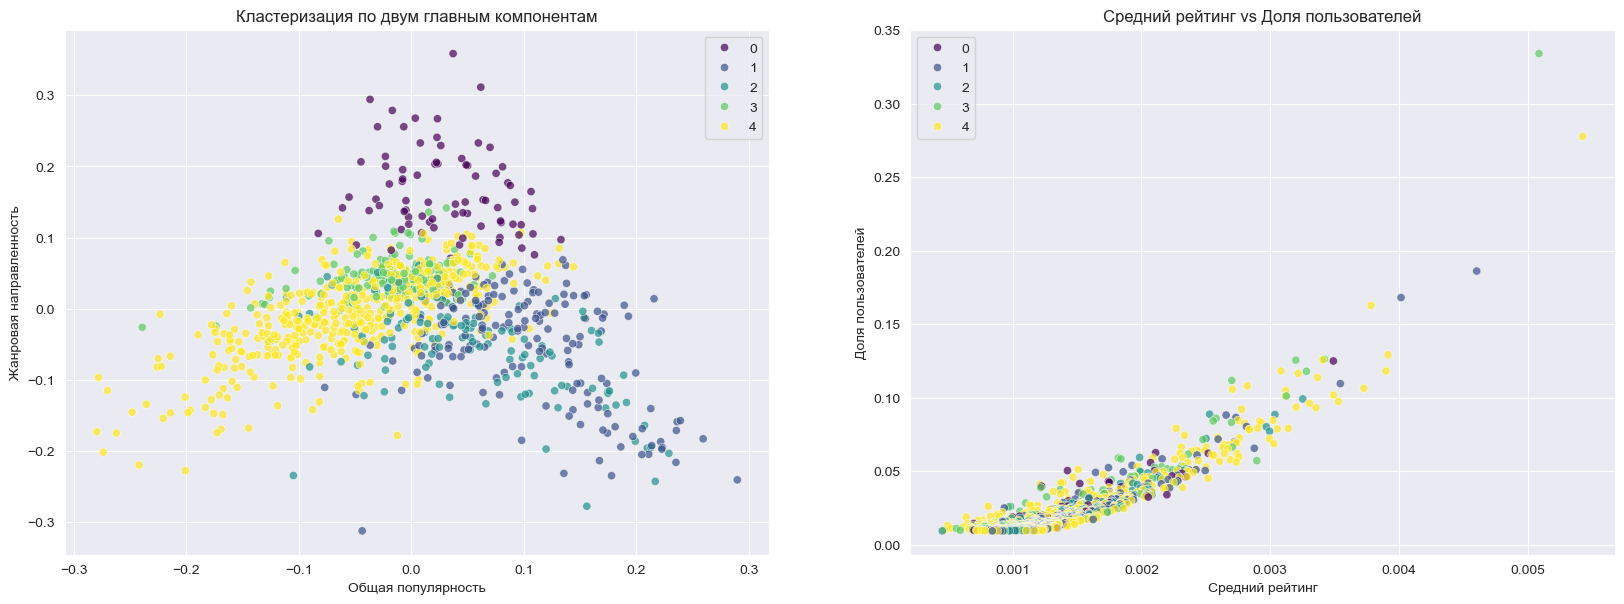

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

plt.figure(figsize=(20, 15))

pca = PCA(n_components=2)
ratings_pca = pca.fit_transform(ratings_normalized)

plt.subplot(2, 2, 1)
sns.scatterplot(x=ratings_pca[:, 0], y=ratings_pca[:, 1], hue=km.labels_, palette='viridis', alpha=0.7)
plt.title('Кластеризация по двум главным компонентам')
plt.xlabel('Общая популярность')
plt.ylabel('Жанровая направленность')

plt.subplot(2, 2, 2)
sns.scatterplot(x=ratings_normalized.mean(axis=1),
                y=(ratings_normalized > 0).mean(axis=1),
                hue=km.labels_, palette='viridis', alpha=0.7)
plt.title('Средний рейтинг vs Доля пользователей')
plt.xlabel('Средний рейтинг')
plt.ylabel('Доля пользователей')

plt.show()

**Ответ:** На первом графике явно видно разделение на кластеры, на втором сложно сказать

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

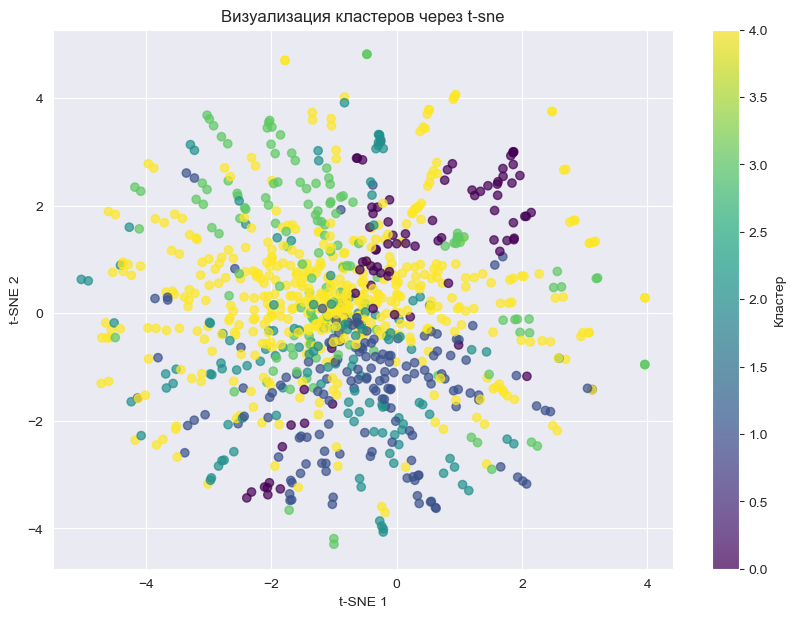

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(ratings)

plt.figure(figsize=(10, 7))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Кластер')
plt.title('Визуализация кластеров через t-sne')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

k_range = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(ratings)
    score = silhouette_score(ratings, labels)
    silhouette_scores.append(score)

optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

print(optimal_k)

KeyboardInterrupt: 

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [28]:
centroids = km.cluster_centers_

closest_artists = []
for i, centroid in enumerate(centroids):
    distances = np.linalg.norm(ratings.values - centroid, axis=1)
    closest_idx = np.argmin(distances)
    closest_artist = ratings.index[closest_idx]
    closest_artists.append((i, closest_artist))

closest_df = pd.DataFrame(closest_artists, columns=['Cluster', 'Closest Artist'])
print(closest_df)

   Cluster       Closest Artist
0        0  murs and 9th wonder
1        1                  jet
2        2    hawthorne heights
3        3         the quitters
4        4         the quitters


**Ответ:** the quitters оказался ближайшим к двум центроидом — значит разделение стало менее четкое

Сделайте t-SNE визуализацию полученной кластеризации.

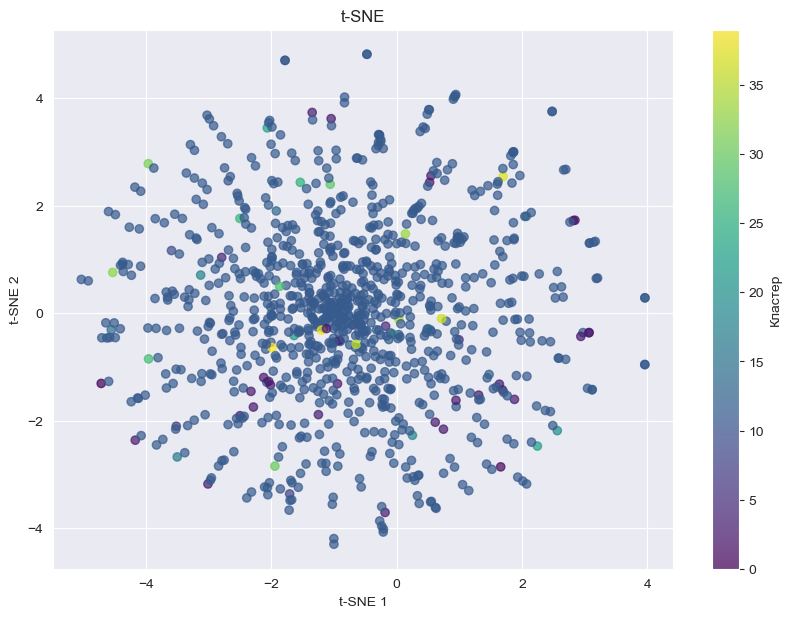

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(ratings)

plt.figure(figsize=(10, 7))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Кластер')
plt.title('t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

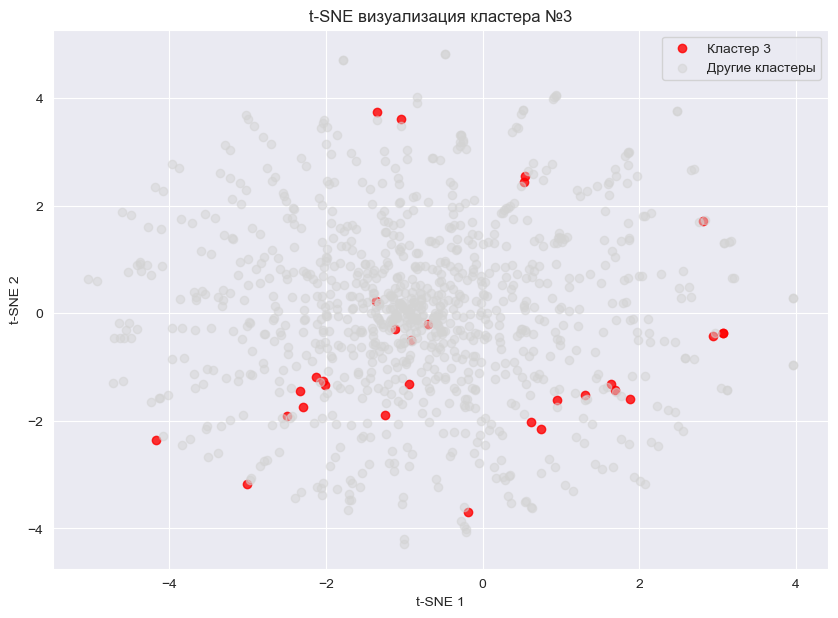

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
ratings_tsne = tsne.fit_transform(ratings)

cluster_number = 3

plt.figure(figsize=(10, 7))

plt.scatter(ratings_tsne[labels == cluster_number, 0],
            ratings_tsne[labels == cluster_number, 1],
            color='red', alpha=0.8, label=f'Кластер {cluster_number}')

plt.scatter(ratings_tsne[labels != cluster_number, 0],
            ratings_tsne[labels != cluster_number, 1],
            color='lightgrey', alpha=0.5, label='Другие кластеры')

plt.title(f't-SNE визуализация кластера №{cluster_number}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()

**Ответ:** Элементы в кластере разбросаны довольно сильно, а это говорит о том, что такой кластер плохо объединяет исполнителей в группы